### Image classification on CIFAR10 dataset using different DL algorithms

In [1]:
import torch
import numpy as np
import torchvision.datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import os

#### Step 1: Load training and testing data

In [2]:
path = 'data'
os.makedirs(path, 644, True);

In [3]:
train_data = CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
labels_map = {
    0: 'Airplane',
    1:'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}


Let's plot a few examples of data

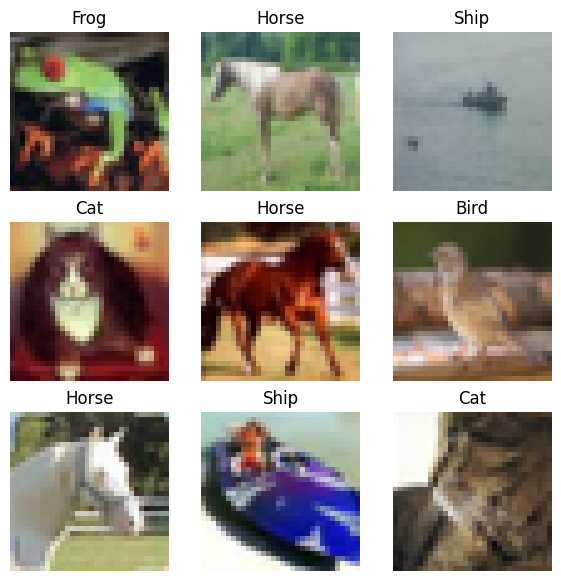

In [5]:
torch.manual_seed(42)
figure = plt.figure(figsize=(7, 7))

cols, rows = 3, 3

for i in range(1, rows * cols + 1):
    image_idx = torch.randint(len(train_data), size=(1, )).item()
    img, label = train_data[image_idx]
    figure.add_subplot(cols, rows, i)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(labels_map[label])
    plt.axis('off')

plt.show()

In [6]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=False
)

#### Step 2: Train TinyVGG model
In this step we initialize TinyVGG model's parameters with random values
and train it on `CIFAR10` dataset

In [7]:
from TinyVGG import TinyVGGModel
torch.manual_seed(42)

img_sample, _ = train_data[0]  # Image sample in format: Channels, Height, Width
model_tvgg = TinyVGGModel(img_sample.shape[0], hidden_units=10, output_shape=len(labels_map))

Let's preview randomly initialized model's accuracy on a few image samples

Model accuracy: 0.00%


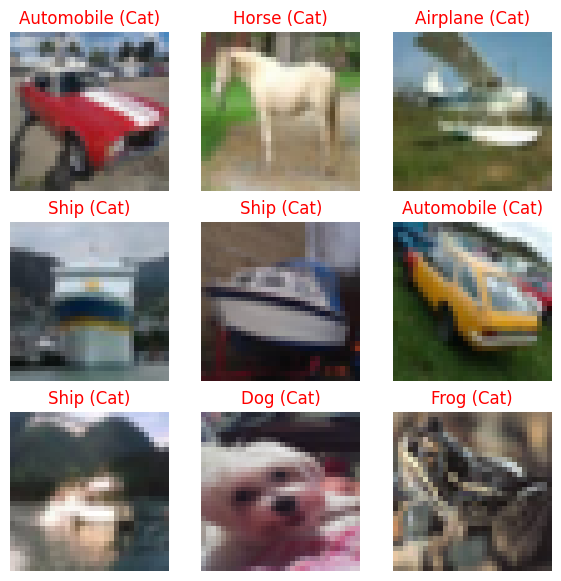

In [8]:
from Utils import plot_sample_predictions
plot_sample_predictions(model_tvgg, train_data, labels_map, 9)

Come as no surprise, the model's accuracy is horrible. So let's begin training it

In [9]:
from Utils import train_step, test_step, accuracy_fn
from tqdm.auto import tqdm
optimizer = torch.optim.SGD(model_tvgg.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
device = 'gpu' if torch.cuda.is_available() else 'cpu'

total_epochs = 0
train_stats = []
test_stats = []

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Total epochs: 72
Train loss = 1.1072789430618286 | Train accuracy = 60.98%
Test loss = 1.178642749786377 | Test accuracy = 58.84%
Epoch: 1 | Total epochs: 73
Train loss = 1.1026735305786133 | Train accuracy = 61.11%
Test loss = 1.2279096841812134 | Test accuracy = 56.76%
Epoch: 2 | Total epochs: 74
Train loss = 1.1000524759292603 | Train accuracy = 61.32%
Test loss = 1.3262004852294922 | Test accuracy = 53.37%
Epoch: 3 | Total epochs: 75
Train loss = 1.096222996711731 | Train accuracy = 61.37%
Test loss = 1.15973961353302 | Test accuracy = 59.00%
Epoch: 4 | Total epochs: 76
Train loss = 1.0915884971618652 | Train accuracy = 61.63%
Test loss = 1.2514272928237915 | Test accuracy = 55.86%
Epoch: 5 | Total epochs: 77
Train loss = 1.0891073942184448 | Train accuracy = 61.64%
Test loss = 1.2103279829025269 | Test accuracy = 58.35%
Epoch: 6 | Total epochs: 78
Train loss = 1.0849908590316772 | Train accuracy = 61.86%
Test loss = 1.308537244796753 | Test accuracy = 56.47%
Epoch: 7 | 

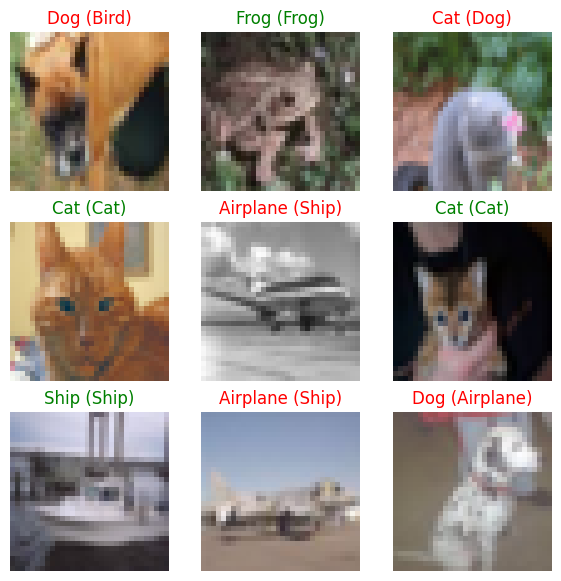

In [26]:
epochs = 15
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch} | Total epochs: {total_epochs}')
    
    train_loss_acc = train_step(
        model=model_tvgg,
        data_loader=train_dataloader,
        accuracy_fn=accuracy_fn,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )
    test_loss_acc = test_step(
        model=model_tvgg,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
    train_stats.append(train_loss_acc)
    test_stats.append(test_loss_acc)
    total_epochs += 1

plot_sample_predictions(model=model_tvgg, dataset=test_data, no_figs=9, labels=labels_map)

In [27]:
# Save model for later training
from pathlib import Path

model_dir = Path('model')
checkpoints = Path('checkpoints')
tiny_vgg_checkpoint = Path('tiny_vgg.tar')

checkpoints.mkdir(parents=True, exist_ok=True)

cp_path = checkpoints / tiny_vgg_checkpoint

torch.save({
    'epoch': total_epochs,
    'model_state_dict': model_tvgg.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_stats': train_stats,
    'test_stats': test_stats
}, cp_path)